In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Import Data

In [2]:
pod_number = 'D3'

In [3]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/D3_raw_features.csv', parse_dates = [0], index_col = 0)

##Declare whether to process raw or filtered data.

In [4]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

####Call the scaling function and create a dataframe with scaled data.

In [10]:
df_scaled, features = scale_features_and_create_day_column(df_all, ref_column)

####Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [11]:
df_tr, df_hold, days_tr = sep_tr_and_holdout(df_scaled, ref_column)

####Create a custom cross-validation function that holds out each day.

In [195]:
lol = create_custom_cv(df_scaled)

#Linear Regression with Base Features

In [196]:
base_features = [pod_ozone,'Temp','Rh']

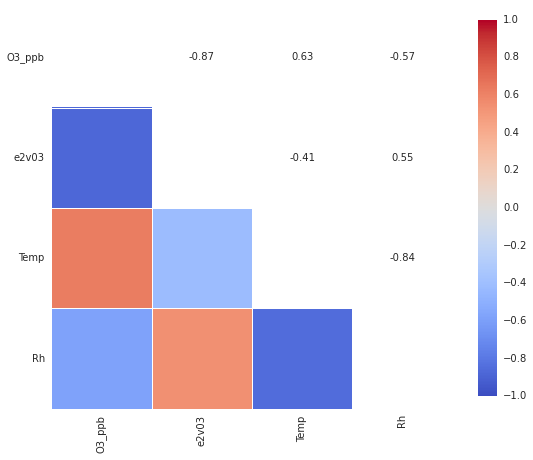

In [197]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [198]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, days_tr, ref_column, lol)

Training RMSE: 5.3
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 8.0 CV High Diff. in Mean.: -14.1 %
Holdout RMSE: 8.0 , High-Value Holdout RMSE: 15.0 Holdout High Diff. in Mean.: -20.6 %


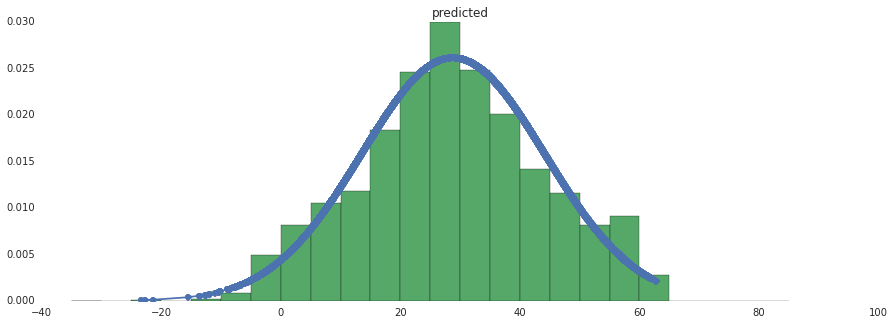

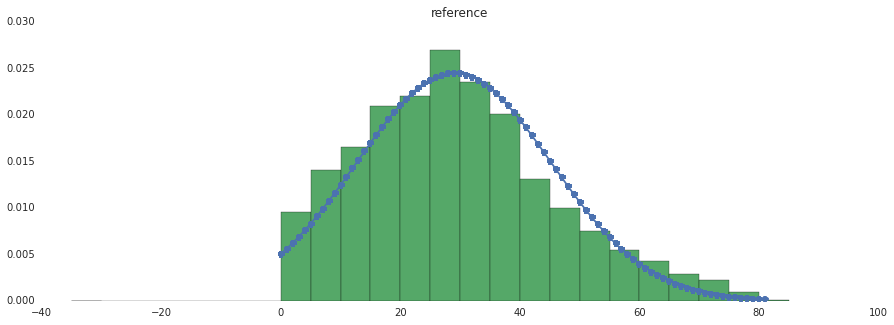

In [199]:
plot_hist(X_pred_cv_base, y_cv, 'predicted')
plot_hist(y_cv, X_pred_cv_base, 'reference')

####Plot the learning curve for a linear regression with the base features.

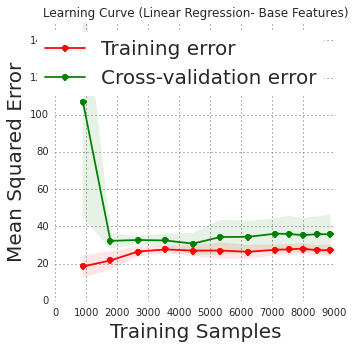

In [200]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,150), lol, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]), 'mean_squared_error')

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

###Plot the residuals and comparison curves.

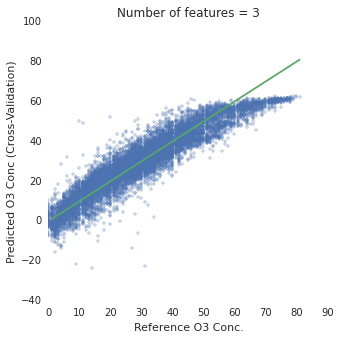

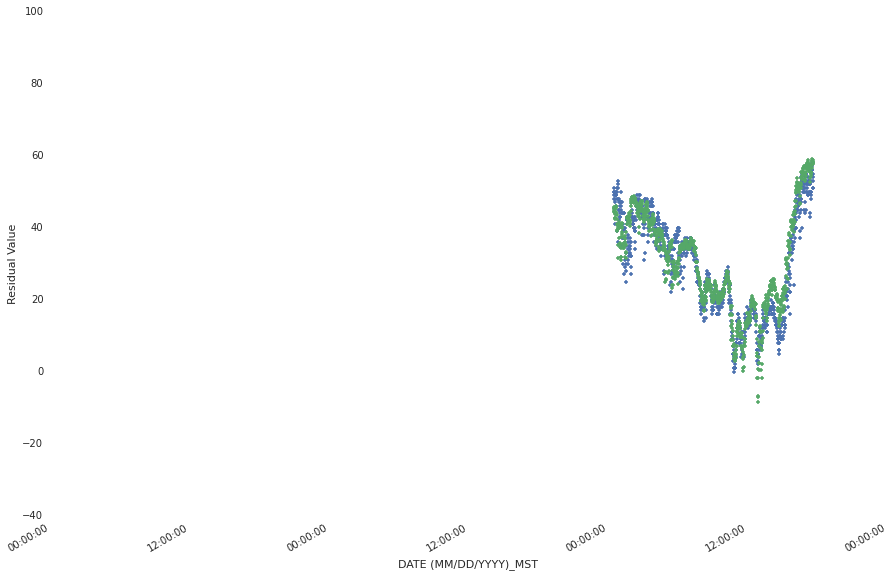

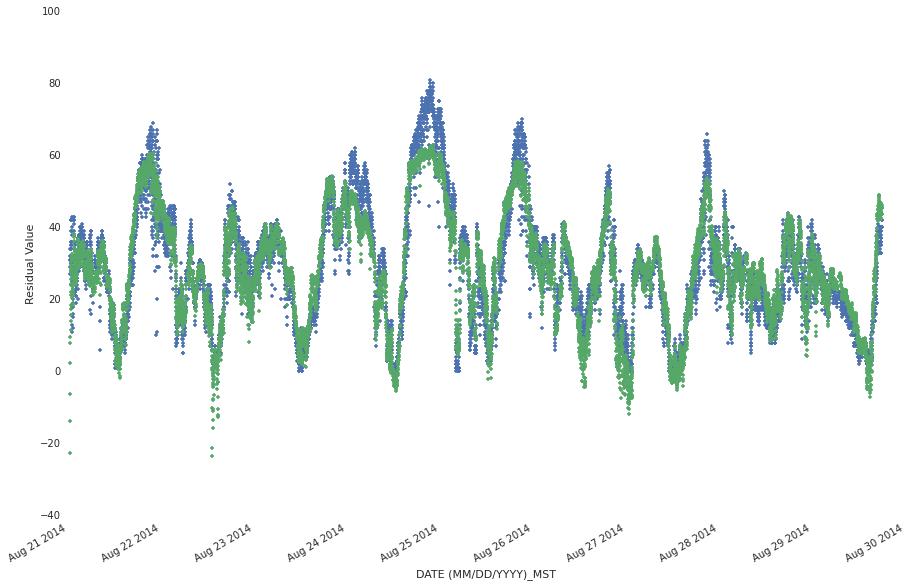

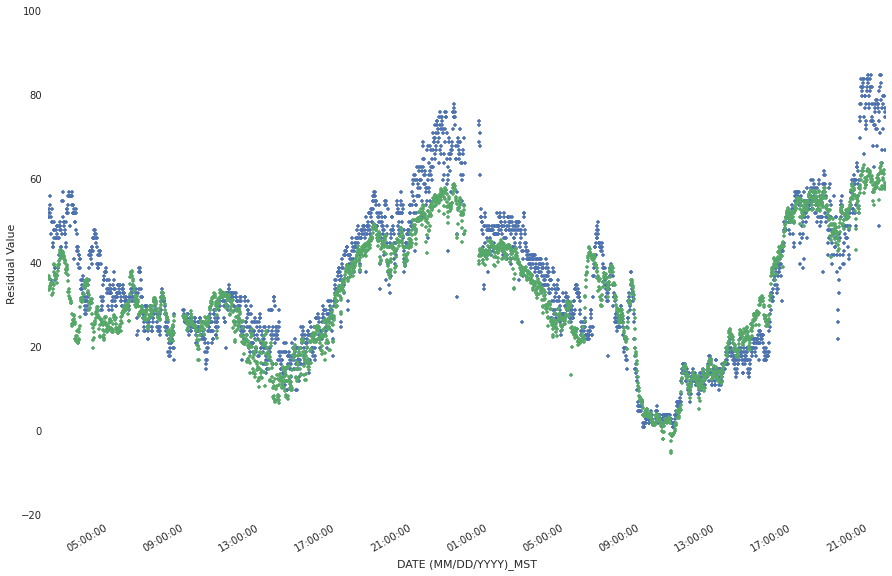

In [201]:
num_good_feat = len(base_features)
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H = find_fitted_cv_values_for_best_features(df_tr, df_hold, base_features, num_good_feat, linear_model.LinearRegression(), days_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
#fitted_vs_ref_plot(df_lin_regr_best_feat_H, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_H, pod_number, 0, ref_column)
#resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)
#resid = plot_resid_vs_conc(df_lin_regr_best_feat_H, ref_column)
#plot_resid_vs_time(resid, pod_number, 1)
#plot_resid_vs_time(resid, pod_number, 2)

###Linear Regression with All Features.

In [128]:
all_features = list(df_tr.ix[:,1:len(df_scaled.columns)-2])
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, days_tr, ref_column, lol)

Training RMSE: 3.3
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 25.0 CV High Diff. in Mean.: -2.1 %
Holdout RMSE: 4.0 , High-Value Holdout RMSE: nan Holdout High Diff. in Mean.: nan %


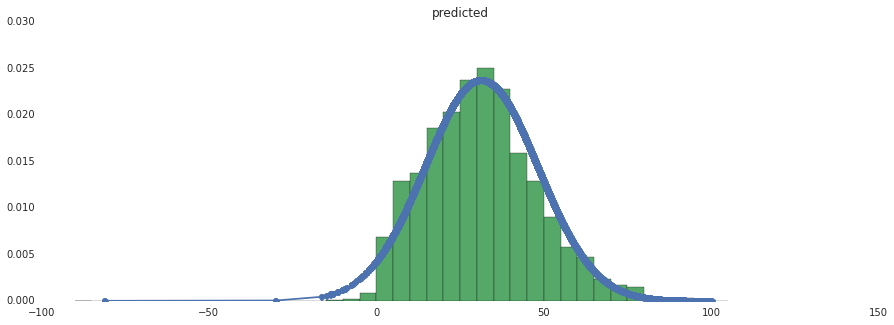

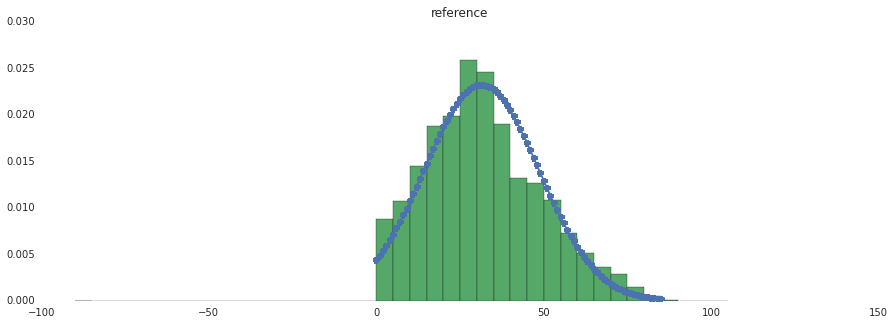

In [129]:
plot_hist(X_pred_cv_all, y_cv, 'predicted')
plot_hist(y_cv, X_pred_cv_all, 'reference')

####Plot a learning curve with all features.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

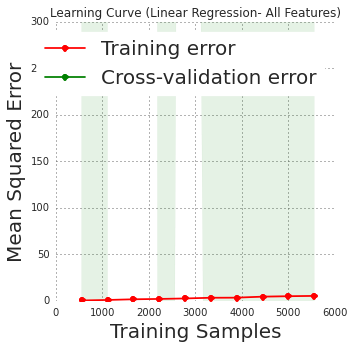

In [56]:
plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- All Features)", df_tr[all_features].values, df_tr[ref_column].values, (0,300), lol, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 'mean_squared_error')

The uncertainty in the cross-validation score is enormous, and it's very far away, from the training score, which indicates that we now have high variance, and need to reduce the number of features.

###Plot the residuals and comparison curves.

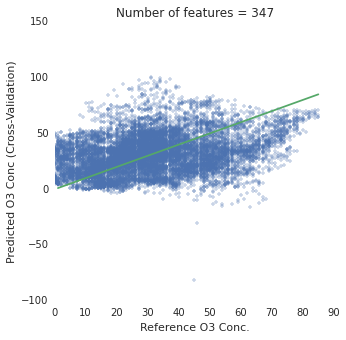

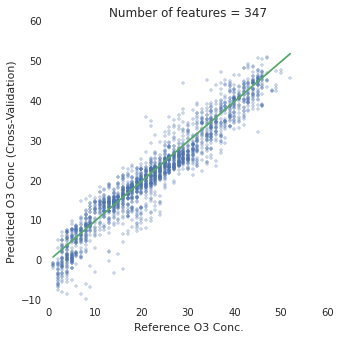

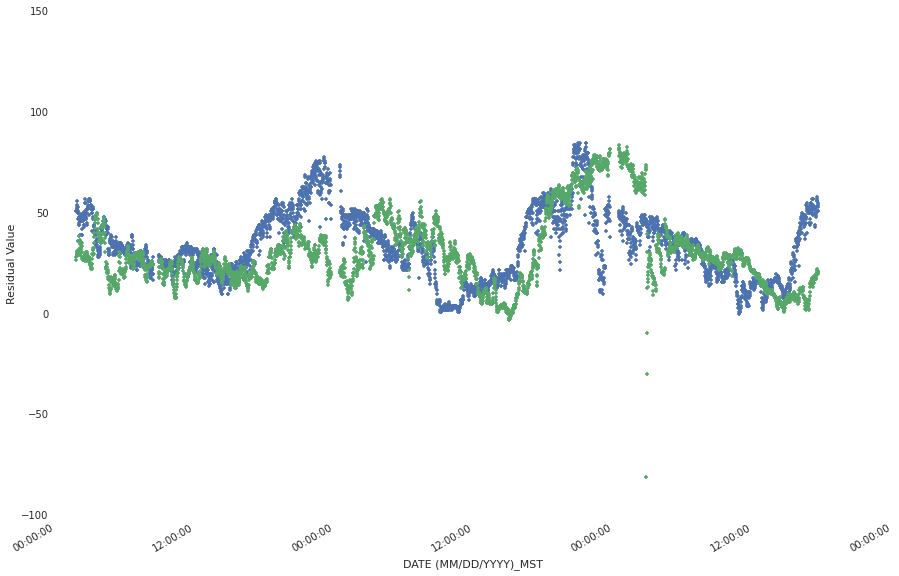

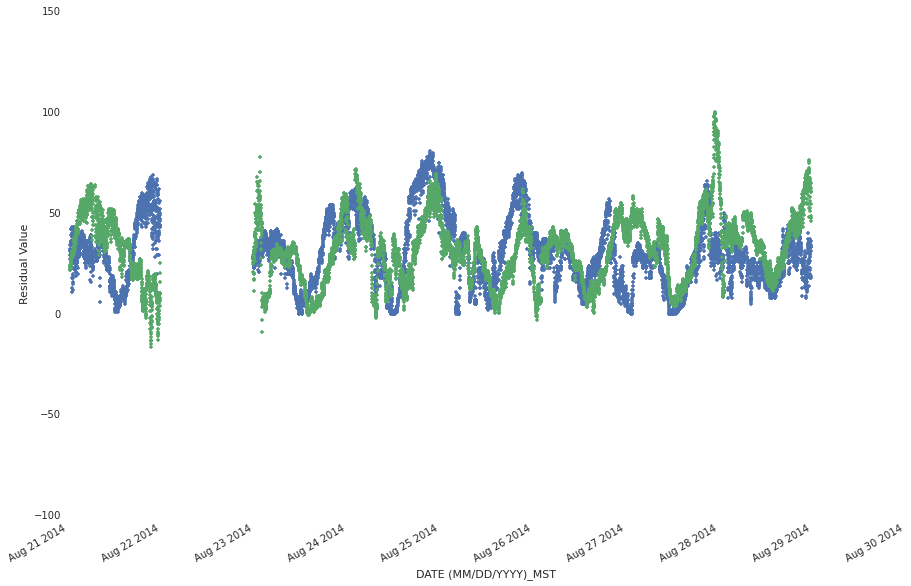

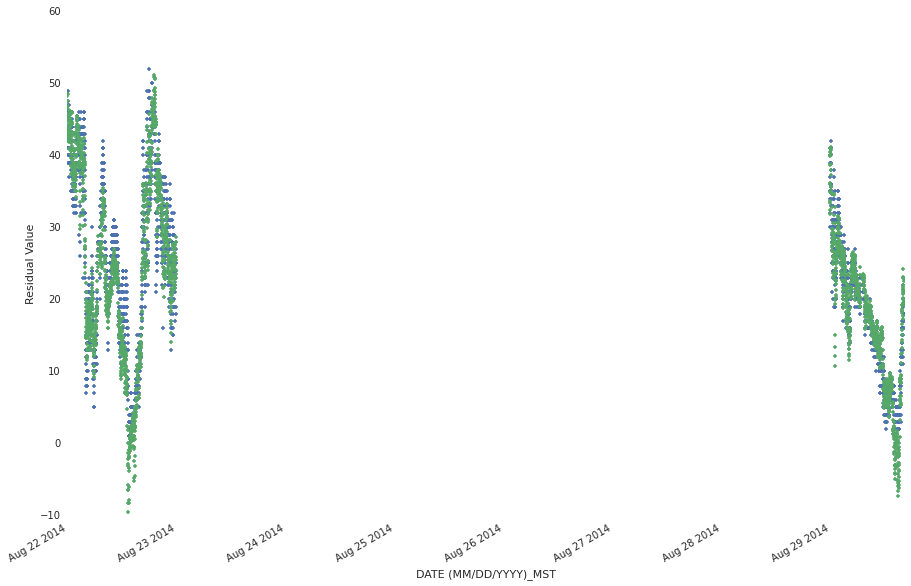

In [131]:
num_good_feat = len(all_features)
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H = find_fitted_cv_values_for_best_features(df_tr, df_hold, all_features, num_good_feat, linear_model.LinearRegression(), days_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_H, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_H, pod_number, 0, ref_column)
#resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)
#resid = plot_resid_vs_conc(df_lin_regr_best_feat_H, ref_column)
#plot_resid_vs_time(resid, pod_number, 1)
#plot_resid_vs_time(resid, pod_number, 2)

#Forward Selection

####Declare rather you want to use MSE or a custom error function:

In [22]:
error_func = 'custom_mse' #'custom_mse', 'custom_mae' or 'mean_squared_error'

In [23]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime',leave_out_pod, ref_column,'days from start', 'day']
features = [f for f in features if f not in leave_out]
fs_features, score, MSE = forward_selection_lodo(lin_regr, features, df_tr[[ref_column] + features + ['days from start']].dropna(), error_func, ref_column, lol)

Next best Feature:  ln_O3_int_lead_5 , Score:  195.7 ,
Next best Feature:  Temp_int_lag_110 , Score:  76.0 ,
Next best Feature:  03_sq_mult_rh_sq , Score:  58.7 ,
Next best Feature:  ln_temp_slope_lead_5 , Score:  46.7 ,
Next best Feature:  ln_temp_int_lag_65 , Score:  39.0 ,
Next best Feature:  ln_o3_rh_slope_lag_110 , Score:  37.7 ,
Next best Feature:  ln_O3_slope_lag_110 , Score:  36.7 ,
Next best Feature:  Rh_slope_lead_50 , Score:  35.7 ,
Next best Feature:  ln_temp_rh_slope_lead_35 , Score:  34.7 ,
Next best Feature:  e2v03_int_lag_65 , Score:  34.7 ,
Next best Feature:  o3_temp_int_lag_95 , Score:  30.7 ,
Next best Feature:  temp_rh_slope_lag_35 , Score:  29.3 ,
Next best Feature:  ln_O3_int_lag_95 , Score:  26.3 ,
Next best Feature:  03_mult_temp , Score:  25.0 ,
Next best Feature:  o3_temp_slope_lag_35 , Score:  24.7 ,
Next best Feature:  e2v03_int_slide_2_to_12_lead , Score:  24.7 ,
Next best Feature:  ln_O3_int_slide_2_to_12_lead , Score:  24.7 ,
Next best Feature:  Temp_int

Custom Score:  ['195.7', '76.0', '58.7', '46.7', '39.0', '37.7', '36.7', '35.7', '34.7', '34.7', '30.7', '29.3', '26.3', '25.0', '24.7', '24.7', '24.7', '24.7', '24.7', '24.7', '24.7', '24.7', '24.7', '25.0', '25.0', '25.0', '25.0', '25.0', '25.0', '25.3', '25.3', '25.7', '26.0', '26.3', '26.3', '27.0', '27.3', '28.0', '28.0', '28.0', '28.0', '28.0', '28.0', '28.0', '28.7', '29.0', '30.0', '30.0', '29.3', '28.0', '27.7', '26.7', '26.3', '26.3', '26.3', '26.3', '26.3', '26.3', '26.3', '27.0']
MSE:  ['101.4', '38.9', '32.5', '33.3', '33.0', '32.7', '32.5', '32.8', '32.9', '32.9', '35.2', '36.1', '36.0', '37.9', '37.7', '37.7', '37.7', '37.7', '37.7', '37.7', '37.7', '37.7', '37.8', '37.7', '37.7', '37.7', '37.7', '37.7', '37.7', '37.9', '37.9', '37.8', '37.8', '38.0', '38.6', '38.4', '38.4', '38.7', '38.7', '38.7', '38.7', '38.7', '38.7', '38.7', '38.8', '39.3', '39.6', '36.7', '37.8', '37.7', '41.0', '41.5', '41.3', '41.3', '41.3', '41.2', '41.0', '36.4', '36.4', '36.4']


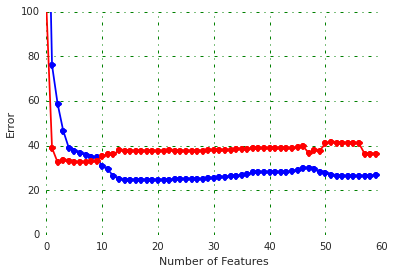

In [43]:
plot_error_vs_features(score, MSE)

#Check Residuals

###Plot cross-validation fitted data versus reference data, and choose number of features.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


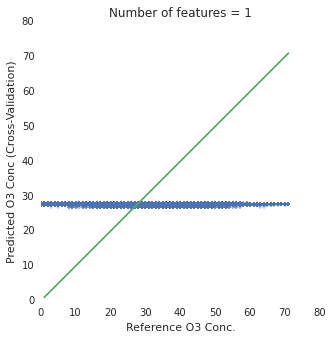

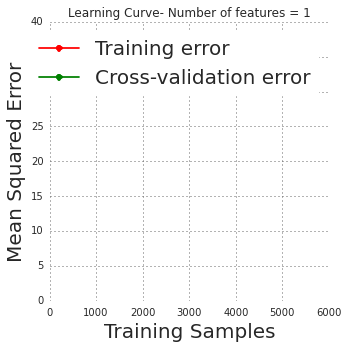

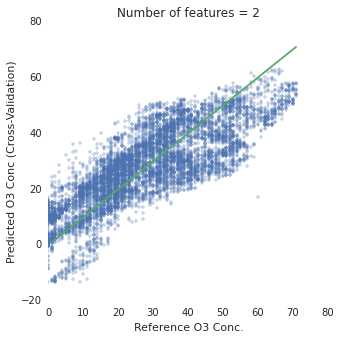

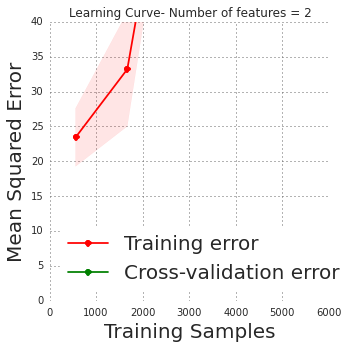

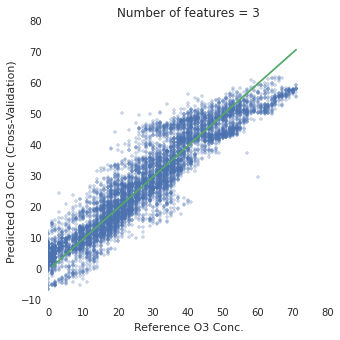

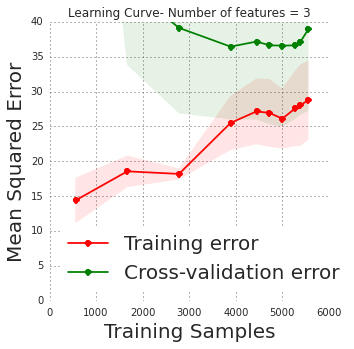

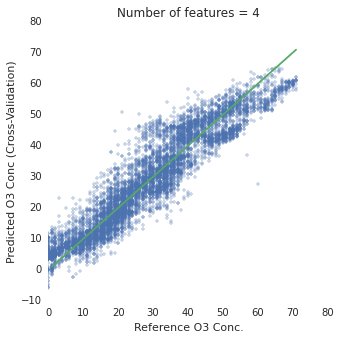

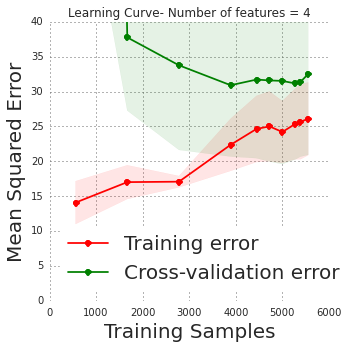

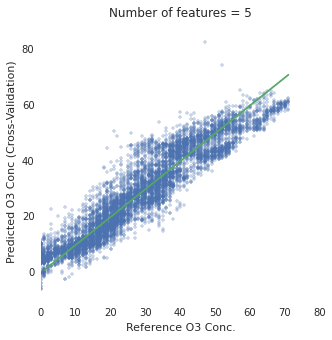

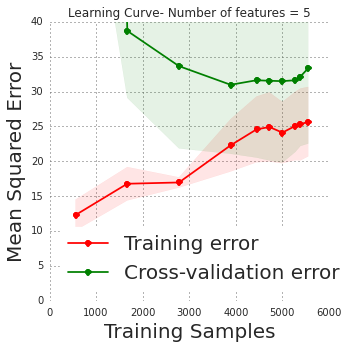

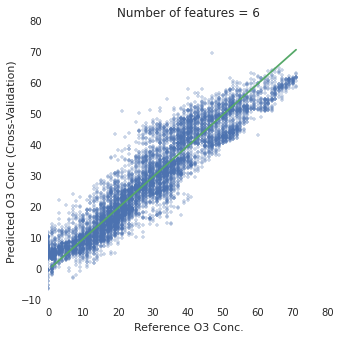

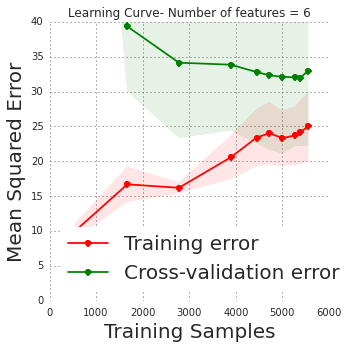

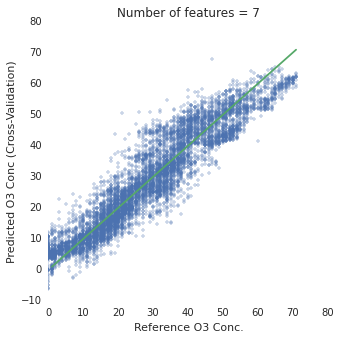

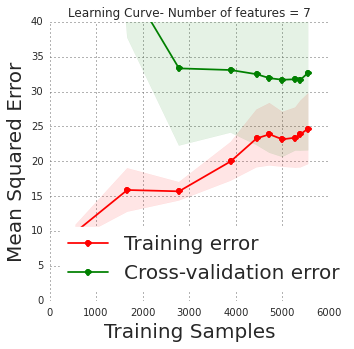

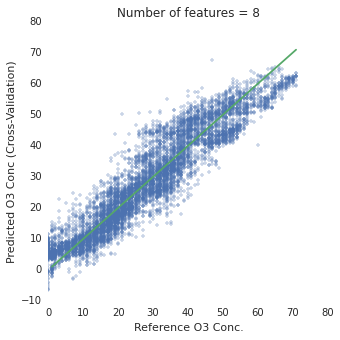

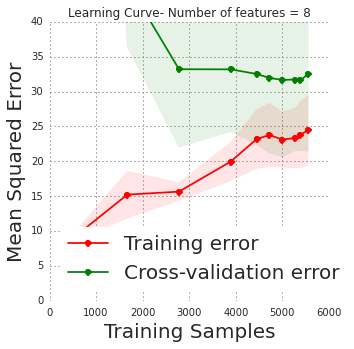

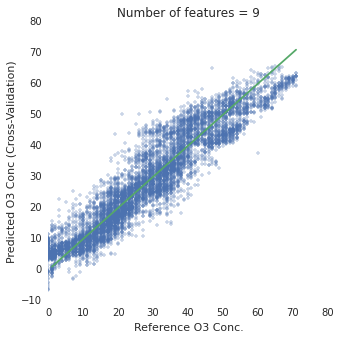

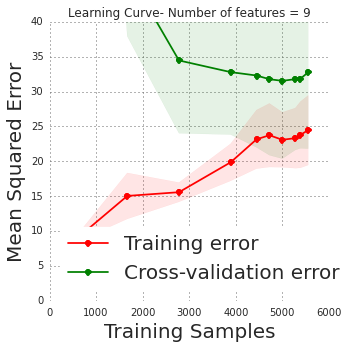

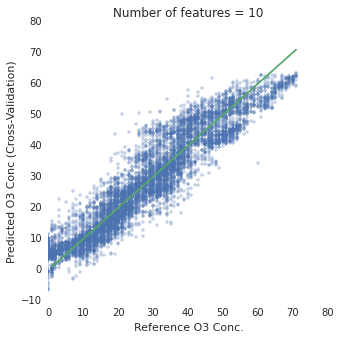

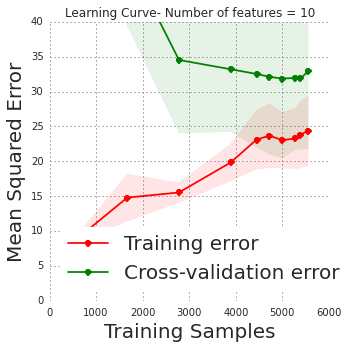

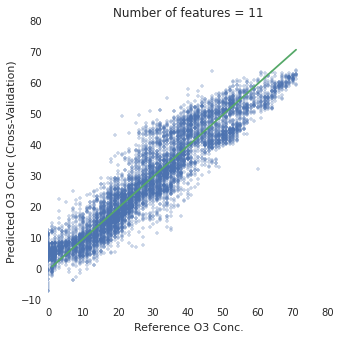

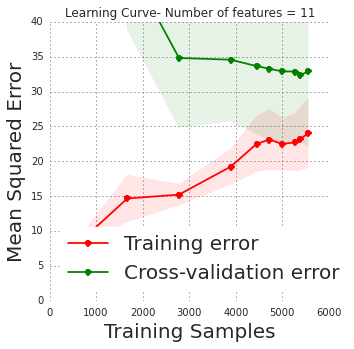

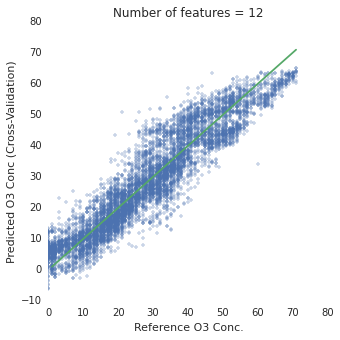

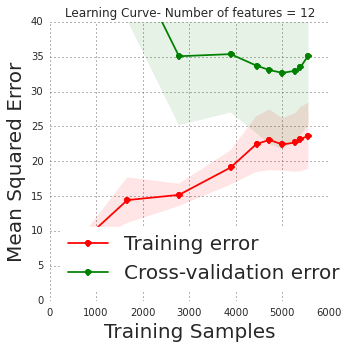

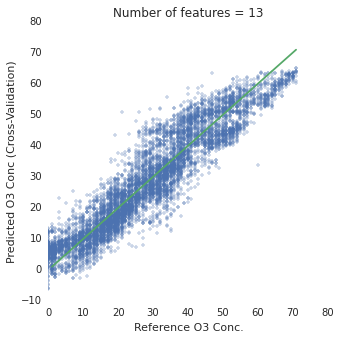

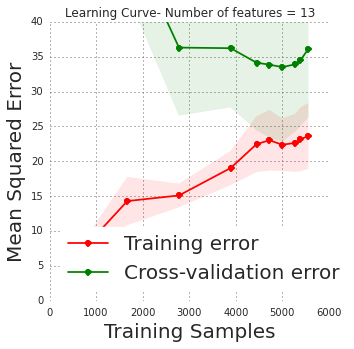

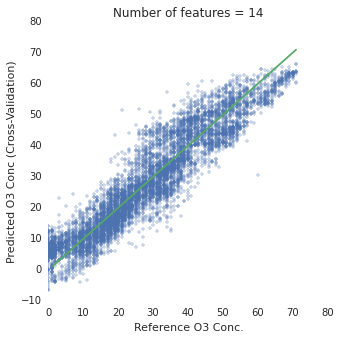

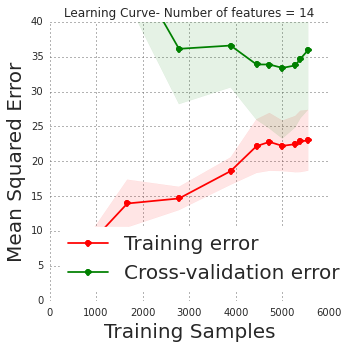

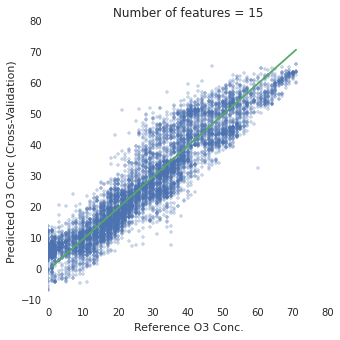

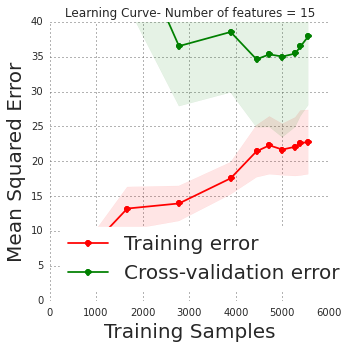

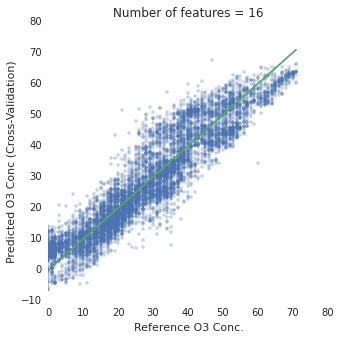

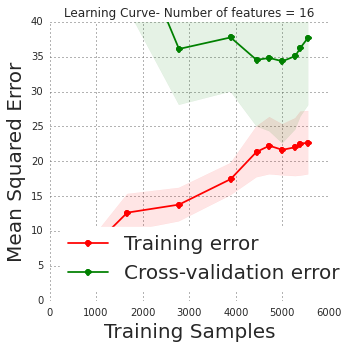

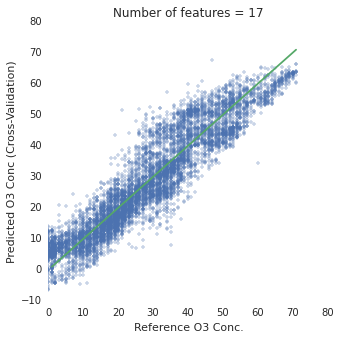

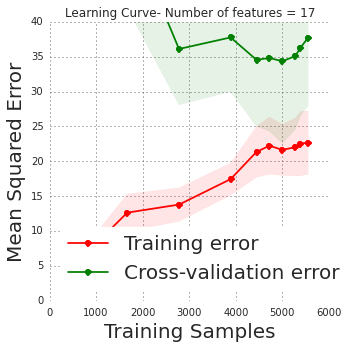

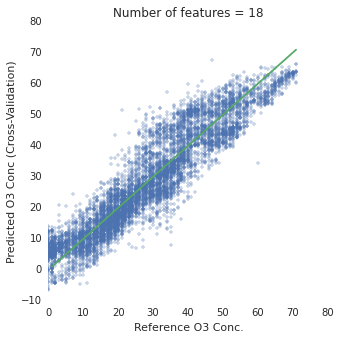

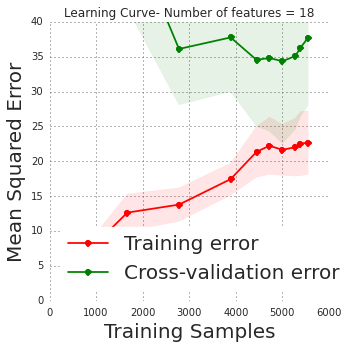

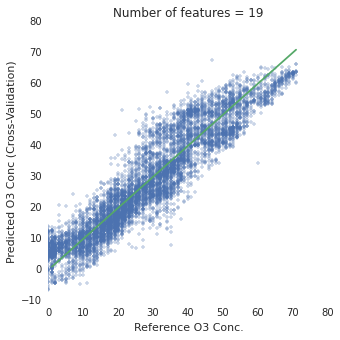

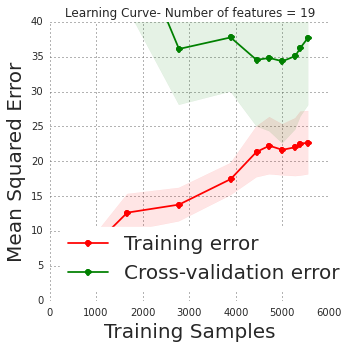

In [44]:
for i in range(1,20):
    num_good_feat = i
    df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), days_tr, ref_column)
    fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,40), lol, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]), 'mean_squared_error')

###Enter the chosen number of features, and plot the cv data and residuals below.

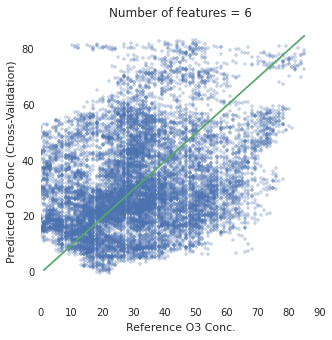

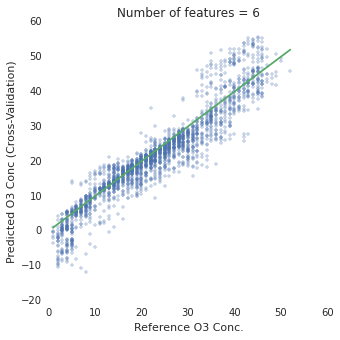

In [133]:
num_good_feat = 6
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), days_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_H, num_good_feat, ref_column)
#plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
#plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
#resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)
#plot_resid_vs_time(resid, pod_number, 1)
#plot_resid_vs_time(resid, pod_number, 2)

##Linear Regression with Best Features

In [132]:
#best_features = fs_features[:num_good_feat]
best_features = ['days from start', 'ln_O3_int_lead_5', 'temp_cu', 'ln_03_mult_ln_rh', 'Rh_int_lag_110', 'e2v03_int_lead_5']
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, days_tr, ref_column, lol)

Training RMSE: 4.8
Cross-Validation RMSE: 5.0 , High-Value CV RMSE: 12.0 CV High Diff. in Mean.: -4.6 %
Holdout RMSE: 4.0 , High-Value Holdout RMSE: nan Holdout High Diff. in Mean.: nan %


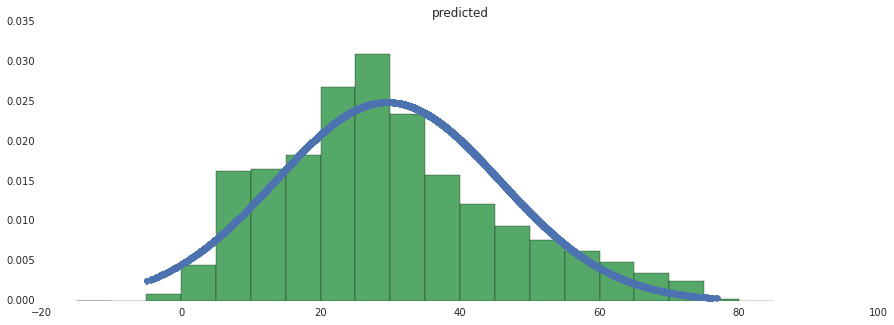

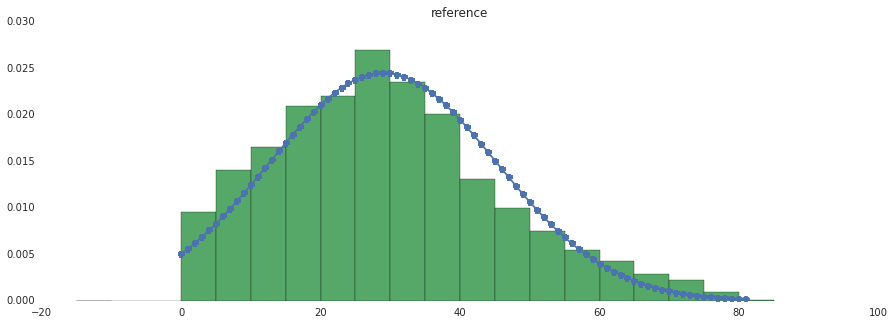

In [88]:
plot_hist(X_pred_cv_best, y_cv, 'predicted')
plot_hist(y_cv, X_pred_cv_best, 'reference')

#Ridge Regression

In [51]:
#fs_features = ['e2v03','Temp','Rh']
fs_features = ['days from start', 'ln_O3_int_lead_5', 'Temp_slope_lead_110', 'ln_temp_slope_lead_110', 'ln_rh_slope_lead_95', 'ln_o3_rh_int_lag_65', 'temp_rh_int_lag_35', 'ln_temp_slope_lag_50', 'temp_rh_int_lead_35', 'e2v03_int_lag_35', 'ln_temp_rh_int_lead_65', 'ln_o3_rh_slope_lead_35', 'ln_temp_slope_lead_20', 'ln_O3_int_lag_5', 'e2v03_slope_lead_5', 'Rh_slope_lead_80', 'ln_temp_slope_lead_80', 'e2v03_int_slide_2_to_12_lead', 'ln_O3_int_slide_2_to_12_lead', 'Temp_int_slide_2_to_12_lead', 'ln_temp_int_slide_2_to_12_lead', 'Rh_int_slide_2_to_12_lead', 'ln_rh_int_slide_2_to_12_lead', 'Temp_slope_lag_80', 'Temp_slope_lag_20', 'temp_mult_rh', 'Temp_slope_lag_35', 'Temp_slope_lag_5', 'Temp_slope_lag_110', 'Temp_slope_lag_95', 'Rh_slope_lag_95', 'ln_temp_slope_lag_65', 'diff', 'Rh_slope_lag_35', 'ln_temp_rh_int_lead_95', 'Rh_slope_lag_110', 'ln_O3_int_slide_25_to_15_lag', 'e2v03_int_slide_25_to_15_lag', 'Temp_int_slide_25_to_15_lag', 'ln_temp_int_slide_25_to_15_lag', 'Rh_int_slide_25_to_15_lag', 'ln_rh_int_slide_25_to_15_lag', 'ln_rh_slope_lag_5', 'ln_rh_slope_lag_20', 'Temp_slope_lead_65', 'Temp_slope_lead_95', 'e2v03_int_lead_65', 'e2v03_slope_lag_5', 'ln_O3_int_lead_20', 'ln_rh_slope_lag_110', 'ln_temp_slope_lag_20', 'e2v03_slope_lead_20', 'Temp_slope_lead_50', 'ln_temp_slope_lead_35', 'ln_temp_slope_lag_35', 'ln_O3_slope_lag_5', 'ln_o3_temp_slope_lead_65', 'ln_temp_slope_lag_95', 'Temp_slope_lag_65', 'ln_temp_slope_lag_80', 'Temp_slope_lag_50']
num_good_feat = len(fs_features)

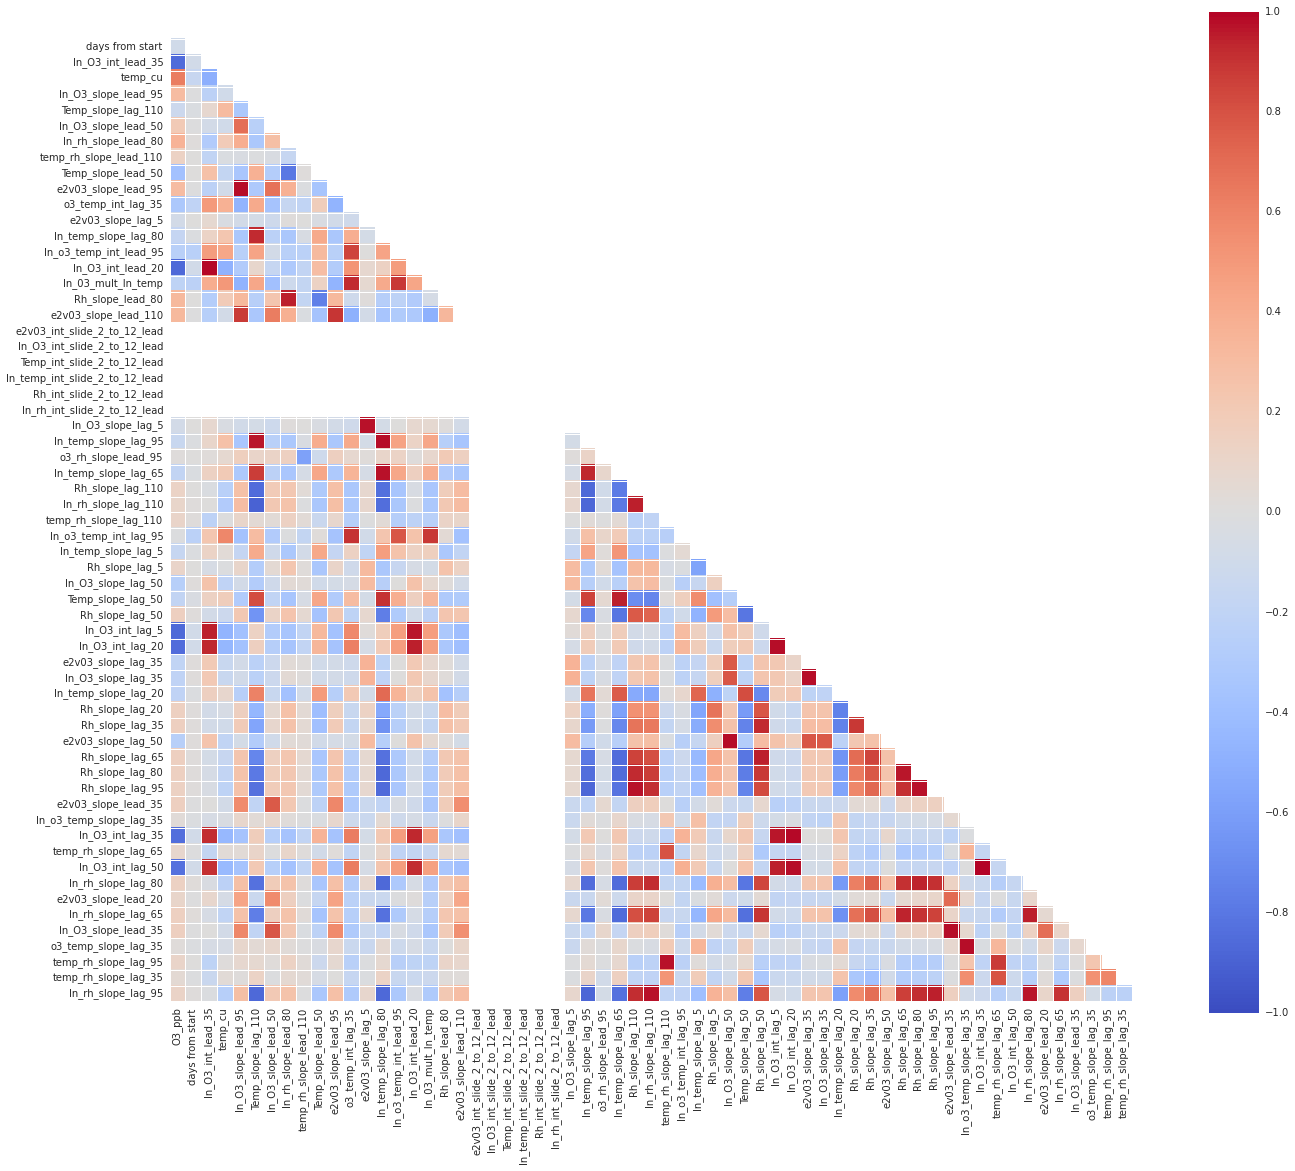

In [52]:
f, ax = plt.subplots(figsize=(20, 20))
sns.corrplot(df_tr[[ref_column] + fs_features], annot=False, sig_stars=False,
             diag_names=False, ax=ax)
f.tight_layout()

In [9]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values

###Find the best lambda value using cross-validation

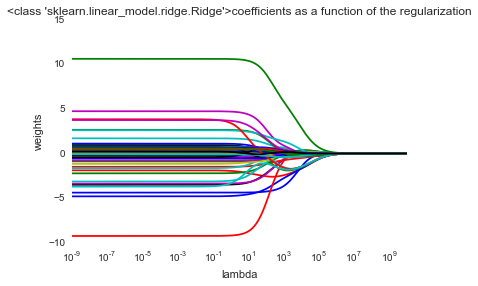

Best Lambda:  1e-09
Custom Error:  15
CV Mean Squared Error:  60


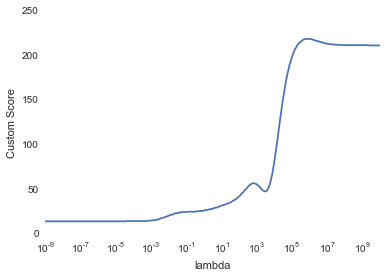

In [15]:
best_lambda_ridge, custom_sc_ridge, MSE_ridge = find_best_lambda(Ridge, fs_features[:num_good_feat], df_fits, ref_column, 'custom_mse', lol, X, y)

####Use the best lambda value found above to find holdout values.

In [57]:
df_ridge_fit = find_residuals_and_fitted_cv_values(Ridge, df_tr, fs_features[:num_good_feat], days_tr, ref_column, best_lambda_ridge)

Coefficients:  [ -2.58031667e-01  -2.48887764e-01   5.76849885e-04   4.89754910e+02
  -9.55232102e+01  -1.67040494e+02  -1.00726287e+03   6.87662423e+01
  -3.21366283e+01  -1.05351090e+01  -2.50392423e-06  -4.11471348e-01
   4.67091217e+02   5.44714205e-04  -6.03701061e-01  -8.15422945e+00
   2.99049522e+01   4.44269356e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.89716263e+01   4.66145372e+02   1.24037790e+01  -9.74540135e+02
   4.09000171e+00  -8.75082042e+01  -1.11309245e+02   2.96554763e-04
   8.90591475e+01   7.59390771e-02  -1.14677643e+02   3.38670918e+01
  -4.05136806e-01   3.09347310e-02   1.20081256e-02   3.11115925e-01
  -1.42159856e+01   1.32276571e+02   1.46084954e+00   6.24185457e+00
   3.28859779e+00  -2.55704041e+01  -7.47518855e+00  -3.50669906e+00
  -1.74936368e+00  -1.52366010e+04   3.55288220e-01   5.27113567e+01
  -2.03255502e-01   4.40610235e+02   1.25665374e+00   6.72697383e+02
   8.94788417e+01  

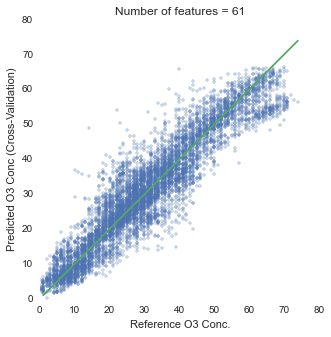

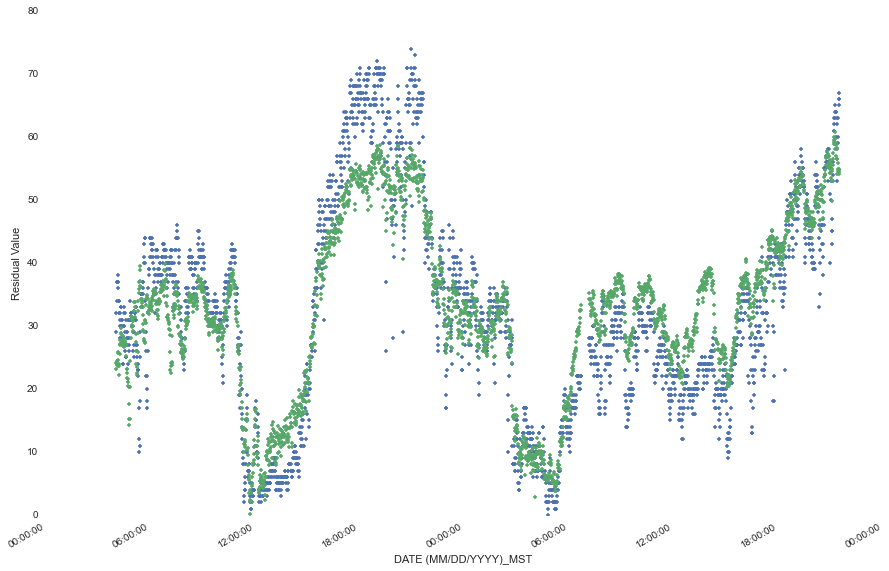

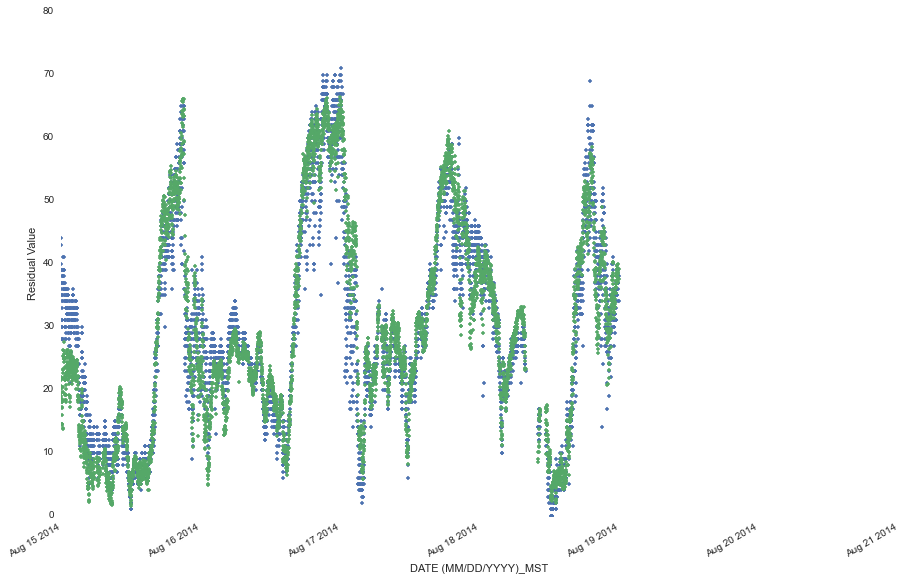

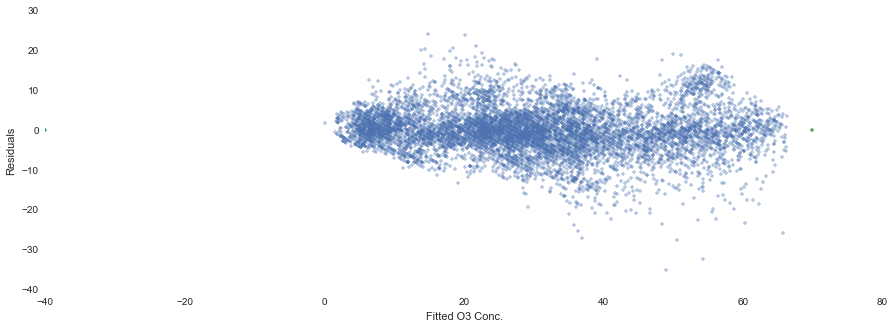

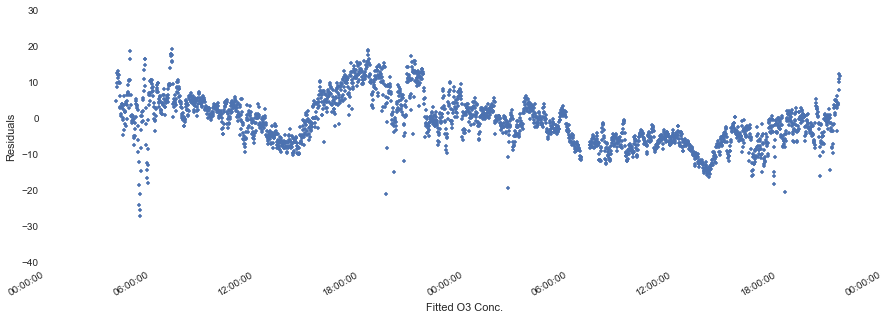

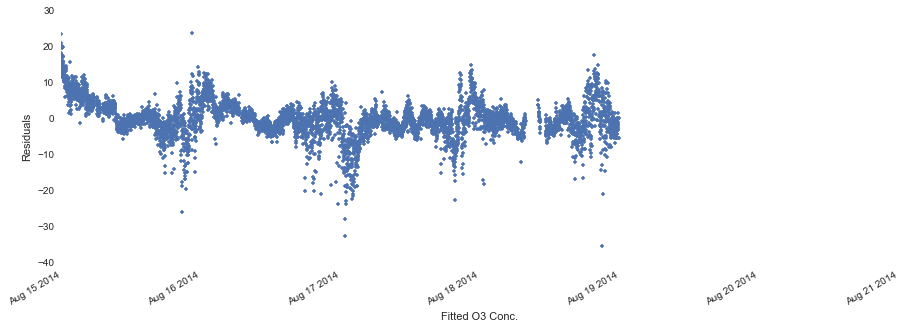

In [49]:
fitted_vs_ref_plot(df_ridge_fit, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_ridge_fit, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_ridge_fit, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_ridge_fit, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

NameError: name 'ridge' is not defined

#Lasso

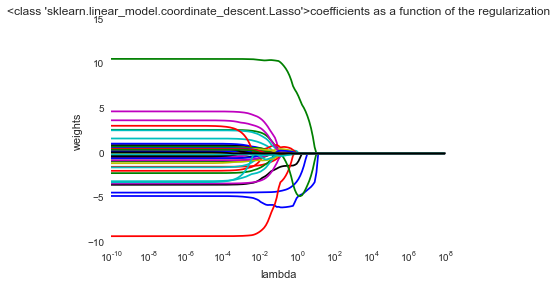

Best Lambda:  1e-10
Custom Error:  15
CV Mean Squared Error:  60


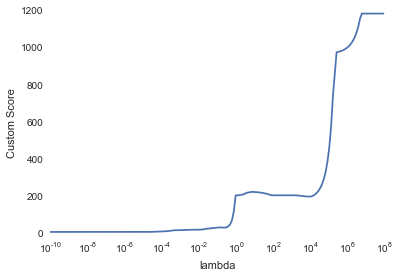

In [58]:
best_lambda_lasso, custom_sc_lasso, MSE_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat], df_fits, ref_column, 'custom_mse', lol, X, y)

####Use the best lambda value found above to find holdout values.

In [59]:
df_fit_lasso = find_residuals_and_fitted_cv_values(Lasso, df_fits, fs_features[:num_good_feat], days_tr, ref_column, best_lambda_lasso)

Coefficients:  [ -2.57905159e-01  -2.51217929e-01   5.76422431e-04   4.85077225e+02
  -9.58650158e+01  -1.64954874e+02  -1.00685245e+03   6.83941343e+01
  -3.20992263e+01  -1.04207041e+01  -2.37177272e-06  -4.06287663e-01
   4.52855217e+02   5.41554363e-04  -5.99541262e-01  -8.17563000e+00
   2.98849145e+01   4.65460980e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.87904152e+01   4.79557339e+02   1.21954254e+01  -9.65409461e+02
   3.80191247e+00  -8.30368735e+01  -1.11403880e+02   2.95951115e-04
   8.85280567e+01   7.36403654e-02  -1.06520528e+02   3.38086145e+01
  -3.40139636e-01  -1.30227494e-02   5.37171679e-02   3.42144555e-01
  -1.41568958e+01   1.34694128e+02   1.47762615e+00   6.15513511e+00
   3.28453490e+00  -2.52587479e+01  -8.39396311e+00  -2.59438003e+00
  -1.74325206e+00  -1.54156959e+04   2.90835085e-01   5.32167904e+01
  -1.72420639e-01   4.66581438e+02   1.26683399e+00   6.63279340e+02
   8.93364798e+01  

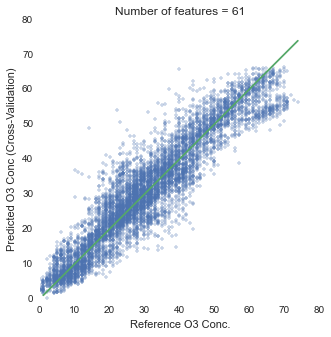

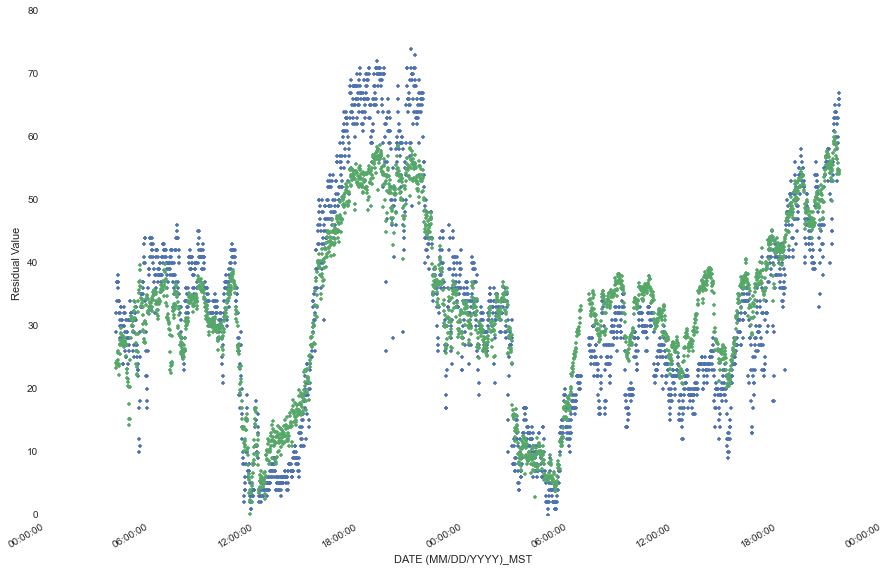

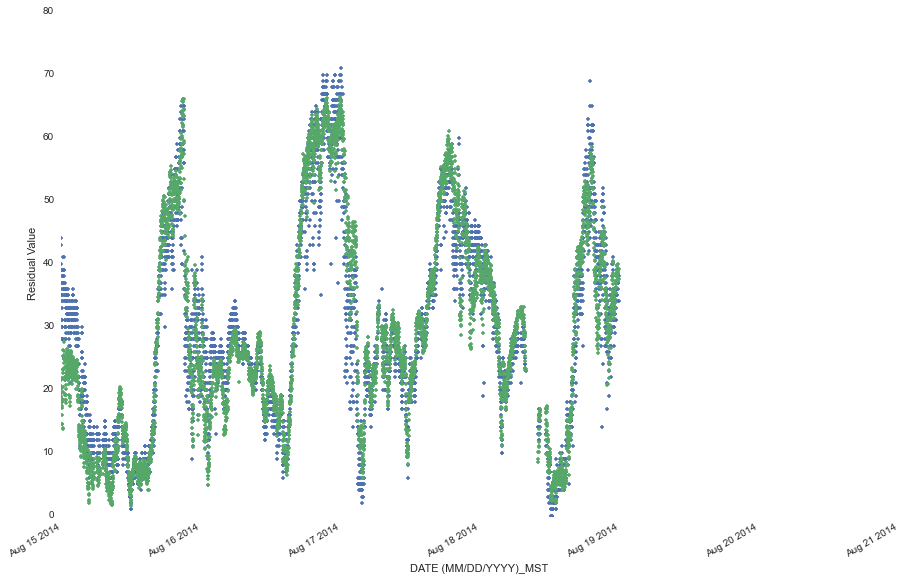

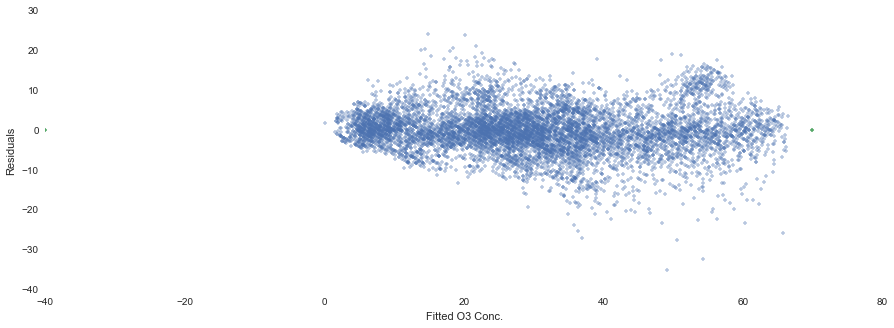

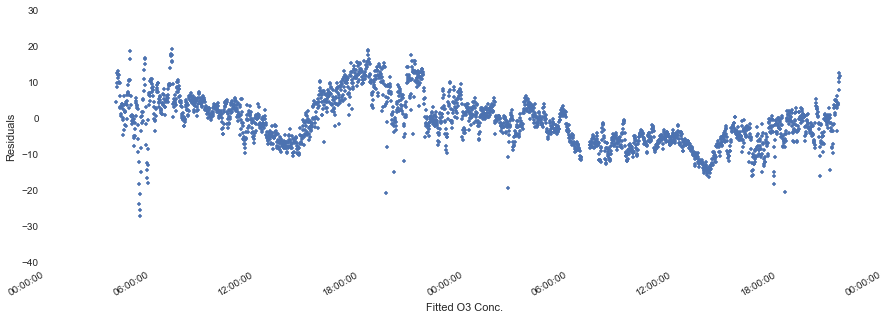

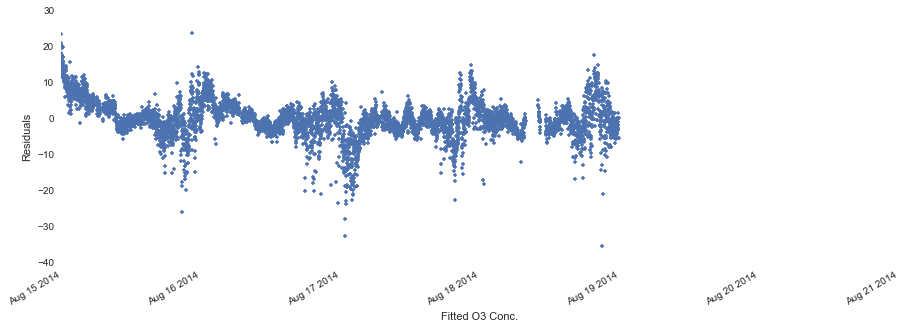

In [61]:
fitted_vs_ref_plot(df_fit_lasso, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_lasso, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Random Forest 

In [9]:
fs_features = ['ln_O3_int_lead_5', 'Temp_int_lag_110', '03_mult_rh_sq', 'ln_rh_slope_lead_110', 'Rh_slope_lead_110', 'ln_temp_slope_lag_35', '03_mult_temp_cu', 'temp_rh_slope_lag_110', 'temp_rh_slope_lag_35', 'ln_temp_slope_lead_65', 'Temp_int_lead_20', 'Temp_slope_lag_65', 'diff', 'Temp_int_lead_5', 'o3_temp_rh_slope_lag_65', 'e2v03_int_lag_95', 'o3_temp_int_lag_95', 'ln_O3_int_lag_95', 'Temp_slope_lag_20', 'Temp_slope_lag_80', 'temp_rh_slope_lead_35', 'e2v03_slope_lead_95', 'o3_rh_int_lead_95', 'e2v03_slope_lead_80', 'ln_O3_slope_lag_20', 'ln_temp_slope_lead_80']
num_good_feat = len(fs_features)

In [63]:
#choose to run default parameters or look for the best parameters (0 = default, 1 = other)
options = 1

In [96]:
if options == 0:
    MSE_CV, df_fit_rf = find_MSE_random_forest(df_fits, fs_features[:num_good_feat], days_tr, options, ref_column)
else:
    MSE_CV = find_MSE_random_forest(df_fits, fs_features[:num_good_feat], days_tr, options, ref_column)

In [85]:
if options == 1:
    #i,j = np.where(MSE_CV == MSE_CV.min())
    #plot_param_select_MSE(MSE_CV, i, j)
    print 'Daily MSE = ', MSE_CV
    print 'mean MSE = ', MSE_CV.mean(axis=2, dtype = int)
else: 
    print 'mean MSE = ', int(np.mean(MSE_CV))
    print 'Daily MSE = ' + str(MSE_CV)

Daily MSE =  [[[ 378.  128.  251.  287.  157.  178.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]]

 [[ 412.  131.  206.  269.  164.  153.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]]

 [[ 333.  133.  236.  244.  109.  125.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.   

In [95]:
if options == 1:
    df_fit_rf = find_fitted_cv_values_for_best_features(df_tr, fs_features, num_good_feat, sk.RandomForestRegressor(n_estimators=300, oob_score = True, n_jobs = -1), days_tr, ref_column)

KeyboardInterrupt: 

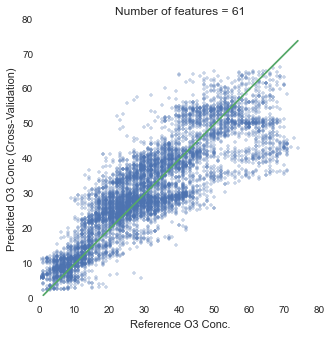

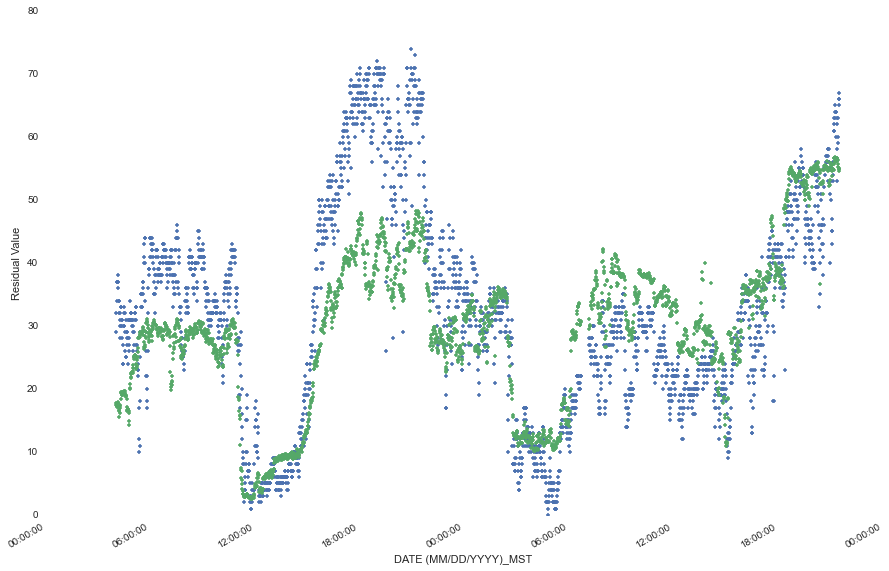

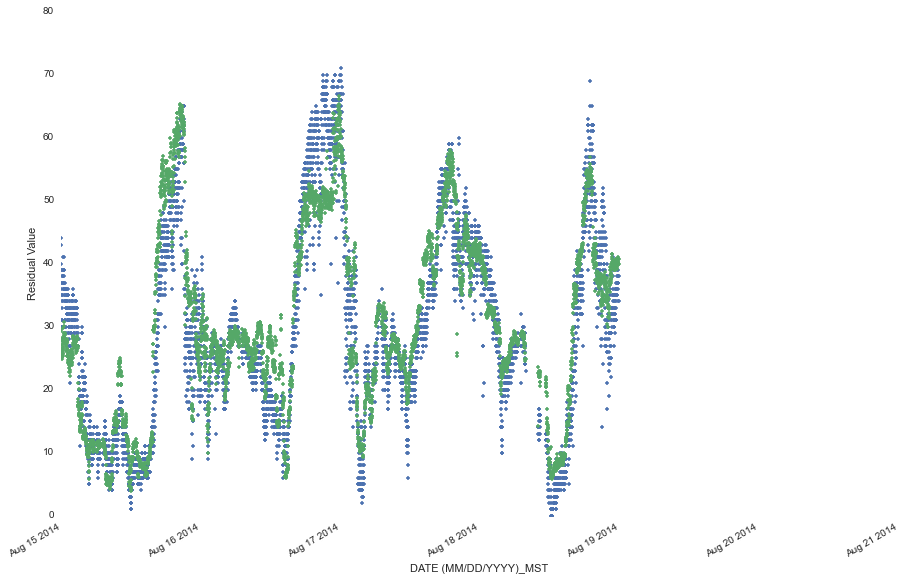

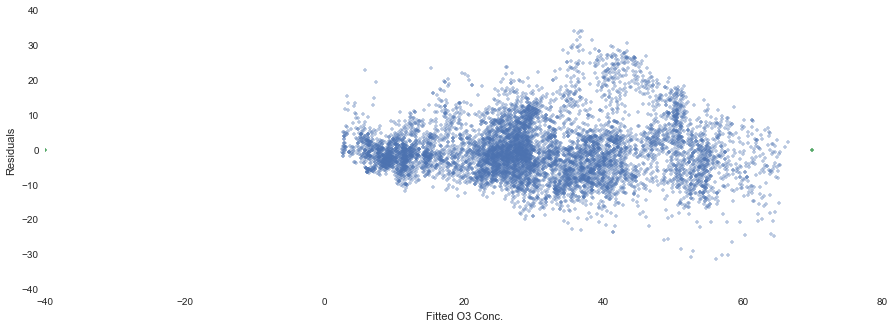

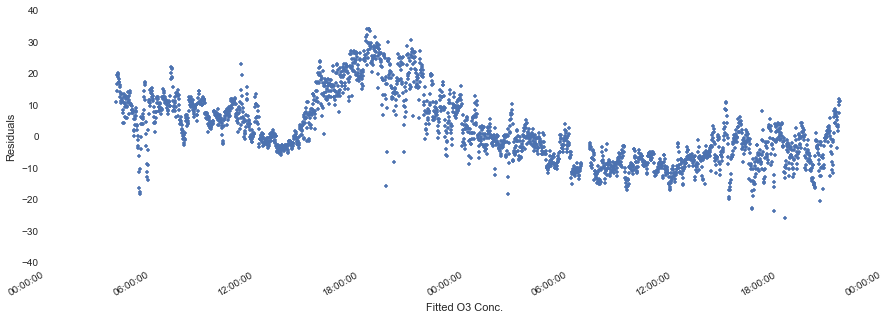

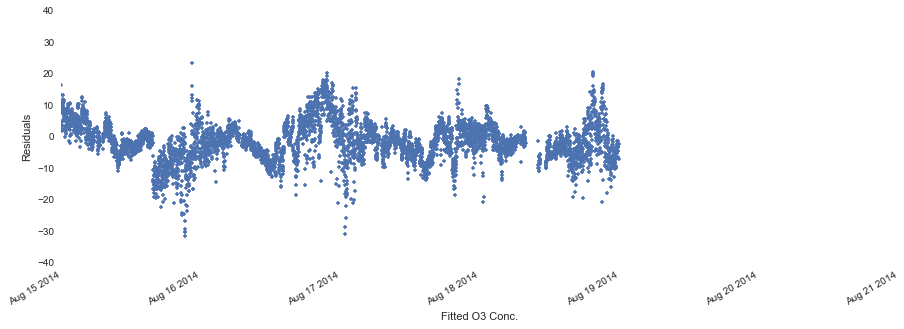

In [97]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Vector Support Machine

In [17]:
fs_features = ['ln_03_mult_ln_rh', 'UnixTime', 'ln_rh_slope_lag_110', 'temp_cu', 'ln_03_mult_ln_temp', 'o3_rh_int_lag_95', 'ln_rh_slope_lead_110', 'ln_O3_int_lag_110', 'o3_temp_int_lag_35', 'ln_o3_rh_slope_lead_110', 'ln_temp_slope_lag_95', 'Temp_slope_lag_80', 'ln_o3_rh_int_lead_35', 'ln_o3_temp_int_lead_95', 'ln_temp_rh_slope_lead_65', 'Temp_slope_lag_95', 'ln_rh_slope_lag_5', '03_sq_mult_rh_sq_&_temp_sq', 'e2v03_int_slide_2_to_12_lead', 'ln_O3_int_slide_2_to_12_lead', 'Temp_int_slide_2_to_12_lead', 'ln_temp_int_slide_2_to_12_lead', 'Rh_int_slide_2_to_12_lead', 'ln_rh_int_slide_2_to_12_lead', 'diff', 'Temp_slope_lead_20', 'ln_rh_slope_lead_5', 'ln_rh_slope_lead_20', 'ln_o3_temp_slope_lag_65', 'o3_temp_slope_lag_95', 'ln_o3_rh_slope_lag_95', 'o3_rh_slope_lag_95', 'ln_o3_temp_slope_lag_110', 'ln_o3_temp_slope_lag_35', 'Temp_slope_lead_5', 'Temp_slope_lag_20']
num_good_feat = 25

In [9]:
def fit_vsm_and_find_MSE(features, df, days, lol, ref_column):
        
    MSE_CV = []
    day_date = []
    df_svm_fit = df_tr.copy()

    for d in days_tr:

        X_T, y_T, X_CV, y_CV = make_numpy_arrays_for_tr_and_holdout(features, df[df.day != d], df[df.day == d], ref_column)   

        parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
        svr = SVR()
        vsm = GridSearchCV(svr, parameters)
        vsm.fit(X_T, y_T)  

        if d == days[0]:
            fitted_CV_o3 = vsm.predict(X_CV)
        else:
            fitted_CV_o3 = np.concatenate((fitted_CV_o3, vsm.predict(X_CV)))
        
        day_date.append(d)  
        MSE_CV.append(int(np.mean(y_CV - vsm.predict(X_CV)**2)))
        
        print d, 'Cross-Val MSE: ', MSE_CV
        print vsm.get_params
        
    print 'Cross-Validation MSE: ', np.mean(MSE_CV)
    return MSE_CV, fitted_CV_o3 

In [11]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVR()
vsm = GridSearchCV(svr, parameters)
vsm.fit(X, y, cv = lol) 

TypeError: fit() got an unexpected keyword argument 'cv'

In [ ]:
MSE_CV_day, fitted_CV_o3_vsm = fit_vsm_and_find_MSE(fs_features, df_tr, days_tr, lol, ref_column)  

In [74]:
vsm.get_params

NameError: name 'vsm' is not defined

In [59]:
fitted_vs_ref_plot(df_fit_lasso, num_good_feat)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_lasso, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

NameError: name 'df_fit_lasso' is not defined

In [ ]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

def fit_vsm_and_find_MSE(features, df_T, df_H, d, days, fitted_holdout_o3, lol):
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = SVR()
    vsm = GridSearchCV(svr, parameters, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False), cv = lol)
    vsm.fit(X_T, y_T)  
    
    
    if d == days[0]:
        fitted_holdout_o3 = vsm.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, vsm.predict(X_H)))
        
    MSE_CV = int(np.mean((y_H - vsm.predict(X_H))**2))
    
    print d,'Cross-Val MSE: ', MSE_CV
    print vsm.get_params
    return MSE_CV, fitted_holdout_o3

In [ ]:
def avg_cv_score_for_all_days(df, features, ref_column, model, scoring_metric):
    X = df[features].values
    y = df[ref_column].values
    if scoring_metric == 'custom_mse':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False)))        
    elif scoring_metric == 'custom_mae':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mae_scoring_function, greater_is_better = False)))        
    else:
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = scoring_metric))
    return score_cv